In [14]:
from sklearn.datasets import make_circles
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
print("Modules loaded")

Modules loaded


In [15]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, factor=0.5, random_state=42)
len(X), len(y)

(1000, 1000)

In [16]:
print(X[:5], y[:5])

[[ 0.46463176  0.15322829]
 [-0.4601531   0.10446773]
 [-0.51775752  0.13568206]
 [-0.26599694  0.42143465]
 [ 0.44220765 -0.89672343]] [1 1 1 1 0]


## Make Dataframe

In [17]:
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles

,X1,X2,label
0,0.464632,0.153228,1
1,-0.460153,0.104468,1
2,-0.517758,0.135682,1
3,-0.265997,0.421435,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.080686,-0.515326,1
998,0.670362,-0.767502,0


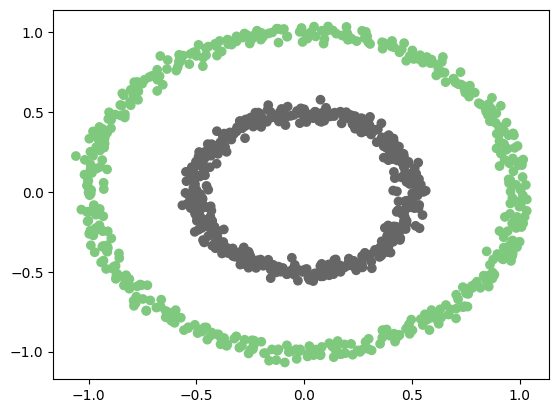

In [18]:
plt.scatter(x=circles.X1, y=circles.X2, c=circles.label, cmap="Accent")

## convert to tensor

In [19]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
X[:5], y[:5]

(tensor([[ 0.4646,  0.1532],
         [-0.4602,  0.1045],
         [-0.5178,  0.1357],
         [-0.2660,  0.4214],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [20]:
X.shape,X.dtype, y.shape, y.dtype

(torch.Size([1000, 2]), torch.float32, torch.Size([1000]), torch.float32)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## Building a model

1. Input layer shape
2. Hidden layers
3. Neurons per hidden layer
4. Output layer shape
5. Hidden activation function
6. Output activation function
7. Loss function

In [22]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model = CircleModel()
model.state_dict()
    

OrderedDict([('layer_1.weight',
              tensor([[ 0.3540,  0.4478],
                      [ 0.4958,  0.7060],
                      [ 0.5409,  0.3411],
                      [-0.2954, -0.5247],
                      [ 0.1339, -0.2036]])),
             ('layer_1.bias',
              tensor([ 0.5889,  0.7019, -0.3157, -0.3006, -0.3604])),
             ('layer_2.weight',
              tensor([[ 0.3300, -0.0870, -0.0375, -0.4319,  0.3244]])),
             ('layer_2.bias', tensor([0.1333]))])

### creating model using `nn.Sequential`

In [23]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4496,  0.0720],
                      [ 0.0954,  0.1139],
                      [ 0.3923,  0.1196],
                      [ 0.6972,  0.6827],
                      [ 0.2876,  0.6407]])),
             ('0.bias', tensor([-0.3617,  0.0680, -0.0310,  0.0163,  0.6561])),
             ('1.weight',
              tensor([[-0.3380,  0.0637,  0.2588, -0.1253,  0.2795]])),
             ('1.bias', tensor([0.2364]))])

In [24]:
with torch.inference_mode():
    untrained_preds = model(X_test)
untrained_preds[:5]

tensor([[0.5241],
        [0.6433],
        [0.4073],
        [0.5680],
        [0.5446]])

## Setup Loss Function and Optimizer

for classification, we use `CrossEntropyLoss` and `Adam` optimizer

More about BCEWithLogitsLoss: https://chat.openai.com/share/3744c35f-2f40-45b5-902c-74378fa75137

1. Input Layer:
   - The input layer receives the input data for your neural network. It could be a vector or a matrix, depending on the nature of the problem you are solving.

2. Hidden Layers:
   - Between the input and output layers, there can be one or more hidden layers.
   - Each hidden layer consists of multiple neurons, and each neuron performs a linear transformation followed by an activation function (such as ReLU).
   - The output of each neuron in the hidden layers becomes the input to the neurons in the subsequent layer.

3. Last Linear Layer:
   - The last linear layer is the final layer before applying an activation function in the neural network.
   - It consists of neurons that perform linear transformations on the inputs received from the previous layer.
   - The outputs of the last linear layer are often referred to as "logits" and represent the raw predictions for each class in a classification problem.

4. BCEWithLogitsLoss:
   - BCEWithLogitsLoss is the loss function used to calculate the error between the predicted logits and the target labels.
   - It takes the logits from the last linear layer and the corresponding target labels as inputs.
   - Internally, it applies the sigmoid function to the logits, transforming them into probabilities.
   - Then, it computes the binary cross-entropy loss by comparing the predicted probabilities with the target labels.

5. Output:
   - The output of the neural network is the computed loss value from BCEWithLogitsLoss.
   - The goal of the neural network training is to minimize this loss value, adjusting the network's weights and biases through backpropagation and gradient descent.

In summary, the input data passes through the hidden layers, reaches the last linear layer, and then undergoes the BCEWithLogitsLoss computation, resulting in a loss value. The loss value is used to guide the training process, enabling the neural network to improve its predictions over time.

In [26]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [27]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_true) * 100
    return acc

## Train model

1. forward pass
2. calculate the loss
3. optimizer zero grad
4. loss backwards (back propagation)
5. optimzer step (gradient descent)



### breakdown 
logits(last linear layer output) -> prediction probabilites(sigmoid for binary and softmax for multiclass) -> prediction labels (argmax)

In [29]:
y_logits = model(X_test)
y_logits[:5]

tensor([[0.5241],
        [0.6433],
        [0.4073],
        [0.5680],
        [0.5446]], grad_fn=<SliceBackward0>)

In [30]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.6281],
        [0.6555],
        [0.6004],
        [0.6383],
        [0.6329]], grad_fn=<SliceBackward0>)

In [32]:
y_pred = torch.round(y_pred_probs)
y_pred[:5]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SliceBackward0>)

In [37]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_test).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        test_loss = loss_fn(y_logits, y_test)
        test_acc = accuracy(y_test, y_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.2f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69 | Train Acc: 50.88% | Test Loss: 0.69 | Test Acc: 49.00%
Epoch: 10 | Train Loss: 0.69 | Train Acc: 51.00% | Test Loss: 0.69 | Test Acc: 49.50%
Epoch: 20 | Train Loss: 0.69 | Train Acc: 50.75% | Test Loss: 0.69 | Test Acc: 49.00%
Epoch: 30 | Train Loss: 0.69 | Train Acc: 50.25% | Test Loss: 0.69 | Test Acc: 49.00%
Epoch: 40 | Train Loss: 0.69 | Train Acc: 50.38% | Test Loss: 0.69 | Test Acc: 48.50%
Epoch: 50 | Train Loss: 0.69 | Train Acc: 50.62% | Test Loss: 0.69 | Test Acc: 48.50%
Epoch: 60 | Train Loss: 0.69 | Train Acc: 51.00% | Test Loss: 0.69 | Test Acc: 48.50%
Epoch: 70 | Train Loss: 0.69 | Train Acc: 51.00% | Test Loss: 0.69 | Test Acc: 49.00%
Epoch: 80 | Train Loss: 0.69 | Train Acc: 51.38% | Test Loss: 0.69 | Test Acc: 49.00%
Epoch: 90 | Train Loss: 0.69 | Train Acc: 51.00% | Test Loss: 0.69 | Test Acc: 47.50%
Epoch: 100 | Train Loss: 0.69 | Train Acc: 50.75% | Test Loss: 0.69 | Test Acc: 47.50%
Epoch: 110 | Train Loss: 0.69 | Train Acc: 51.25% | Te

## Visualize the results

In [38]:
# refer to the course repo for the full code

## Improve the model

1. More hidden layers
2. more hidden units
3. more epochs
4. change activation function
5. change the learning rate
6. change the loss function